# Does being a plus member increase customer lifetime value? (Causal Inference)

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import dowhy
import warnings
from dowhy import CausalModel
import dowhy.datasets

# Suppress the specific FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

print("All packages imported successfully!")

All packages imported successfully!


## Generate synthethic data

In [60]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
N = 1000

# Generate synthetic features
income = np.random.normal(50000, 5000, N)  # Annual income

# Define a function to determine plus member status based on income
def determine_plus_member(income):
    # Calculate the probability of being a plus member using a logistic function
    probability = 1 / (1 + np.exp(-(income - 50000) / 2000))
    
    # Generate and return a binary outcome (0 or 1) based on the calculated probability
    return np.random.binomial(1, probability)

# Generate binary feature for plus_member
plus_member = np.array([determine_plus_member(inc) for inc in income])

# Generate customer lifetime value (CLV) with some noise
clv = 0.08 * income + 500 * plus_member + np.random.normal(0, 2000, N)

# Create a DataFrame
data = pd.DataFrame({
    'income': income,
    'plus_member': plus_member,
    'clv': clv
})

data.head()

,income,plus_member,clv
0,52483.570765,1,4080.267507
1,49308.678494,0,2440.381468
2,53238.442691,1,5397.424436
3,57615.149282,1,7790.112835
4,48829.233126,0,155.993711


## Plot logistic function and empirical distribution
$$P(\text{plus\_member} \mid \text{income} = x) =  \frac{1}{1 + e^{-\frac{x - 50000}{5000}}}$$

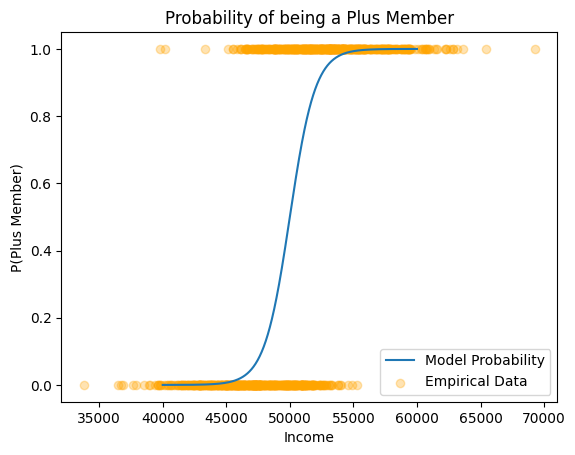

In [63]:
# Plot income and plus_member probability
x = np.linspace(40000, 60000, 1000)
y = 1 / (1 + np.exp(-(x - 50000) / 1000))


plt.plot(x, y, label='Model Probability')
plt.scatter(data['income'], data['plus_member'], alpha=0.3, label='Empirical Data', color='orange')
plt.xlabel('Income')
plt.ylabel('P(Plus Member)')
plt.title('Probability of being a Plus Member')
plt.legend()
plt.show()

## Plot income distribution of plus vs non-plus members

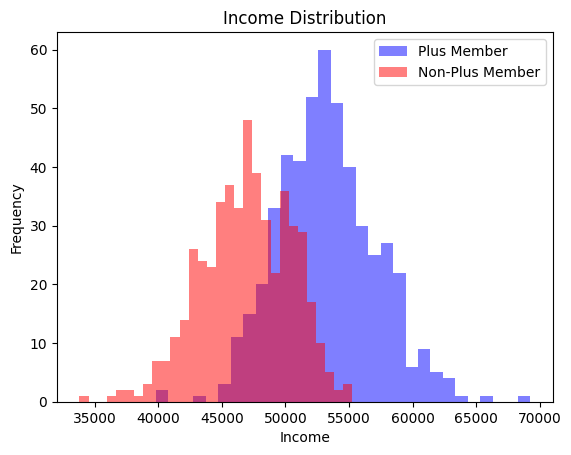

In [64]:
# Plot income distribution for plus_member and non-plus_member
plt.hist(data[data['plus_member'] == 1]['income'], bins=30, alpha=0.5, label='Plus Member', color='blue')
plt.hist(data[data['plus_member'] == 0]['income'], bins=30, alpha=0.5, label='Non-Plus Member', color='red')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.legend()
plt.show()

## Create a causal graph and a model

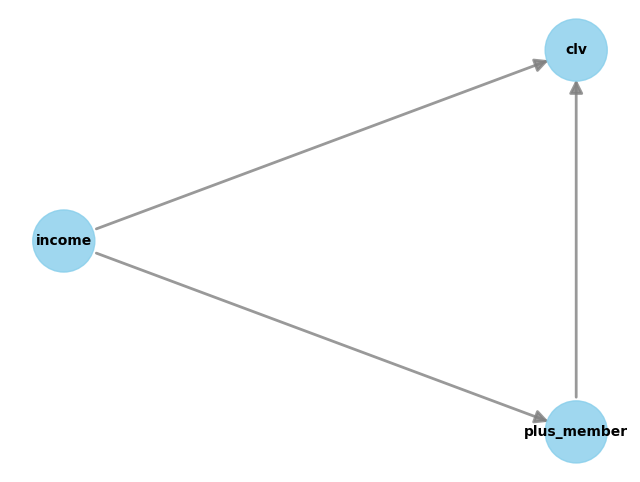

In [5]:
# Formalize causal graph using a Directed Acyclic Graph (DAG)
graph = """
digraph {
    income -> plus_member;
    income -> clv;
    plus_member -> clv;
}
"""

# Create a causal model instance
model = CausalModel(
    data=data,
    treatment='plus_member',
    outcome='clv',
    graph=graph
)

# Visualize the causal DAG
model.view_model()
plt.show()

## Identify the causal effect

In [29]:
# Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

# Interpret the causal effect
print('Interpretation: This expression represents the causal effect of plus_member on clv (Customer Lifetime Value), controlling for income.')

# Explain backdoor, frondoor, instrumental variable
print('''
-Backdoor criterion is used to identify a set of variables that block all backdoor paths between the treatment and the outcome.
-Frontdoor criterion involves identifying a set of mediating variables that allow for causal inference even with unmeasured confounders.
-Instrumental variable is a variable that affects the treatment but has no direct effect on the outcome except through the treatment.
''')

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
──────────────(E[clv|income])
d[plus_member]               
Estimand assumption 1, Unconfoundedness: If U→{plus_member} and U→clv then P(clv|plus_member,income,U) = P(clv|plus_member,income)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Interpretation: This expression represents the causal effect of plus_member on clv (Customer Lifetime Value), controlling for income.

-Backdoor criterion is used to identify a set of variables that block all backdoor paths between the treatment and the outcome.
-Frontdoor criterion involves identifying a set of mediating variables that allow for causal inference even with unmeasured confounders.
-Instrumental variable is a variable that affects the treatment but has no direct effect on the outcome except through the treatment.



## Estimate the causal effect

In [35]:
# Estimate the causal effect using linear regression
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)

# Interpret the estimate
print('Interpretation: The estimated effect of being a plus member on customer lifetime value (CLV) is approximately 523. This means that being a plus member is associated with an increase in CLV of $523, on average.')

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
──────────────(E[clv|income])
d[plus_member]               
Estimand assumption 1, Unconfoundedness: If U→{plus_member} and U→clv then P(clv|plus_member,income,U) = P(clv|plus_member,income)

## Realized estimand
b: clv~plus_member+income
Target units: ate

## Estimate
Mean value: 523.0045193280566

Interpretation: The estimated effect of being a plus member on customer lifetime value (CLV) is approximately 523. This means that being a plus member is associated with an increase in CLV of $523, on average.


## Refute the estimate using a placebo test

In [22]:
## Refute the estimate using a placebo test
refute_placebo = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute_placebo)

# Interpret the placebo test
print('Interpretation: The placebo test indicates that the new effect is not statistically significant (p-value > 0.05). This suggests that the original estimated effect is robust and not likely due to random chance.')

Refute: Use a Placebo Treatment
Estimated effect:523.0045193280566
New effect:-0.3845773702560837
p value:0.94

Interpretation: The placebo test indicates that the new effect is not statistically significant (p-value > 0.05). This suggests that the original estimated effect is robust and not likely due to random chance.


## Refute the estimate using a data subset refuter

In [23]:
# Refute the estimate using a data subset refuter
refute_subset = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print(refute_subset)

# Print interpretation of the subset refuter
print('Interpretation: The data subset refuter indicates that the estimated causal effect is robust to subsampling of the data. This suggests that the estimated effect is not driven by any specific subset of the data.')

Refute: Use a subset of data
Estimated effect:523.0045193280566
New effect:528.6865995317817
p value:0.8999999999999999

Interpretation: The data subset refuter indicates that the estimated causal effect is robust to subsampling of the data. This suggests that the estimated effect is not driven by any specific subset of the data.
